<a href="https://colab.research.google.com/github/zakonreal/etc./blob/main/project_churn_modelling_14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Цель исследования** — построить модель, которая поможет предсказать уход клиента.

**Ход исследования**:
1. Загрузка и изучение общей информации о датафреймах
2. Предобработка данных
3. Подготовка данных
4. Построение модели
6. Тестирование модели
7. Вывод

In [1]:
RANDOM_STATE = 42

## Изучение общей информации

### Импорт необходимых библиотек

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

import phik

# from pandas_profiling import ProfileReport

### Открытие файлов

In [4]:
contract_data = pd.read_csv('/datasets/contract_new.csv', sep=',', engine='python')

In [5]:
personal_data = pd.read_csv('/datasets/personal_new.csv', sep=',', engine='python')

In [6]:
internet_data = pd.read_csv('/datasets/internet_new.csv', sep=',', engine='python')

In [7]:
phone_data = pd.read_csv('/datasets/phone_new.csv', sep=',', engine='python')

### Вывод первых десяти строк таблицы

In [8]:
contract_data.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [9]:
personal_data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [10]:
internet_data.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [11]:
phone_data.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


### Вывод основной информации о датафреймах

In [12]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [13]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [14]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [15]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [16]:
contract_data.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


In [17]:
personal_data.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [18]:
internet_data.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [19]:
phone_data.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


### Вывод

Согласно документации к данным, датафреймы имеют следующую информацию:
- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Описание полей данных:
- `BeginDate` – дата начала пользования услугами,
- `EndDate` – дата окончания пользования услугами,
- `Type` – тип договора: ежемесячный, годовой и т.д,
- `PaperlessBilling` – факт выставления счёта на электронную почту,
- `PaymentMethod` – способ оплаты,
- `MonthlyCharges` – ежемесячные траты на услуги,
- `TotalCharges` – всего потрачено денег на услуги,
- `Dependents` – наличие иждивенцев,
- `Senior Citizen` – наличие пенсионного статуса по возрасту,
- `Partner` – наличие супруга(и),
- `MultipleLines` – наличие возможности ведения параллельных линий во время звонка.

Целевым признаком будет являться столбец `EndDate` из датафрейма `contract_data`.

Данные не имеют дубликатов, но в датафреймах неравное количество строк: в `contract_data` и `personal_data` 7043 строки, в `internet_data` 5517 строк и в `phone_data` 6361 строка. Необходимо будет объединить датафреймы и провести предобработку данных.

**План работы:**
1. Провести предобработку данных;
2. Подготовить данные для дальнейшей работы с моделью: определить информативные и неинформативные признаки, разбить данные на выборки, преобразовать категориальные признаки в численные и промасштабировать признаки;
3. Построить несколько различных моделей с разными параметрами для выбора лучшей по метрике AUC-ROC;
4. Протестировать модель;

## Предобработка данных

### Соединение датафреймов

Соединим все датафреймы с помощью столбца `customerID`:

In [20]:
data = contract_data.join(
    personal_data.set_index('customerID'), on='customerID').join(
    phone_data.set_index('customerID'), on='customerID').join(
    internet_data.set_index('customerID'), on='customerID')

Рассмотрим датафрейм после объединения:

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [22]:
data.describe()

,MonthlyCharges,SeniorCitizen
count,7043.000000,7043.000000
mean,64.761692,0.162147
std,30.090047,0.368612
min,18.250000,0.000000
25%,35.500000,0.000000
50%,70.350000,0.000000
75%,89.850000,0.000000
max,118.750000,1.000000


### Изменение названий столбцов датафреймов

In [23]:
data.columns = data.columns.str.replace(r"([A-Z])",
                                        r" \1",
                                        regex=True).str.lower().str.replace(' ', '_').str[1:]

In [24]:
data = data.rename(columns={'ustomer_i_d' : 'customer_id',
                            'ender' : 'gender',
                            'streaming_t_v' : 'streaming_tv'})

In [25]:
data.columns

Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges', 'gender',
       'senior_citizen', 'partner', 'dependents', 'multiple_lines',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')

### Обработка целевого признака

Явного целевого признака в датафрейме нет, поэтому необходимо создать столбец `target`, в котором значения будут равны 0, если в столбце `end_date` значение `No`, и 1, если в столбце `end_date` любое другое значение.

In [26]:
data.loc[data['end_date'] == 'No', 'target'] = 0

In [27]:
data.loc[data['end_date'] != 'No', 'target'] = 1

In [28]:
data['target'] = data['target'].astype('int')

### Заполение пропусков

В столбце `total_charges` были замечены незаполненные значения. Так как в этом столбце значения — это сумма, которую заплатил клиент за все время пребывания с компанией, то можно предположить, что значения пустуют, если клиенты на момент выгрузки данных еще ничего не платили.

In [29]:
data.loc[data['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,...,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,No,0
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,...,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,...,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,0
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,...,Yes,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,0
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,...,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,...,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,...,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,...,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,Female,0,...,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,0


01.02.2020 — это как раз дата выгрузки данных, поэтому можно заполнить пропущенные значения 0:

In [30]:
data.loc[data['total_charges'] == ' ', 'total_charges'] = 0

После соединения датафреймов появились пропущенные значения, так как не все клиенты пользовались всеми услугами компании. Можем заполнить пропущенные значения на `No`:

In [31]:
data = data.fillna('No')

### Изменение типов данных

Чтобы изменить тип данных столбца `end_date` заменим все значения `No` на `2020-02-01`, так как это дата выгрузки данных.

In [32]:
data.loc[data['end_date'] == 'No', 'end_date'] = '2020-02-01'

Теперь можем изменим тип данных колонок `end_date` и `begin_date` на datetime:

In [33]:
data['begin_date'] = pd.to_datetime(data['begin_date'])

In [34]:
data['end_date'] = pd.to_datetime(data['end_date'])

Изменим тип данных `total_charges` на float:

In [35]:
data['total_charges'] = data['total_charges'].astype('float')

### Анализ и графики

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

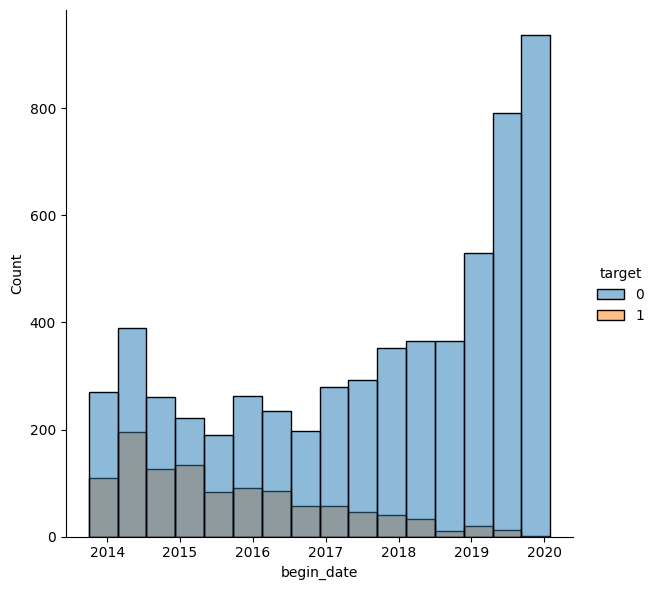

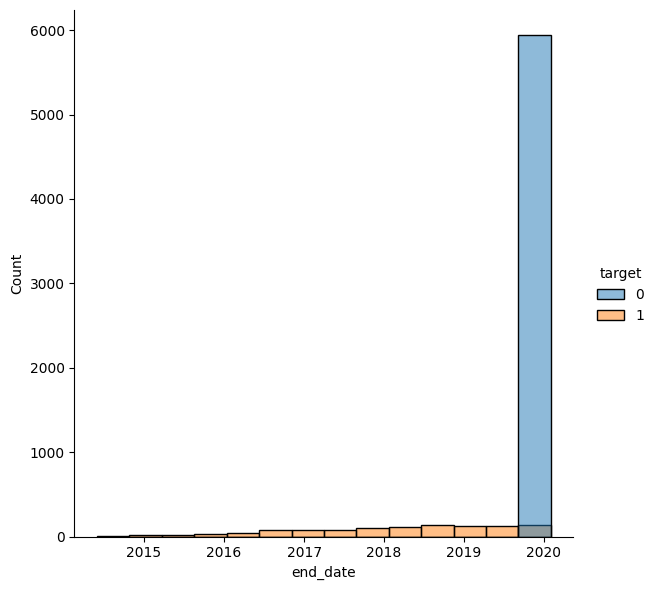

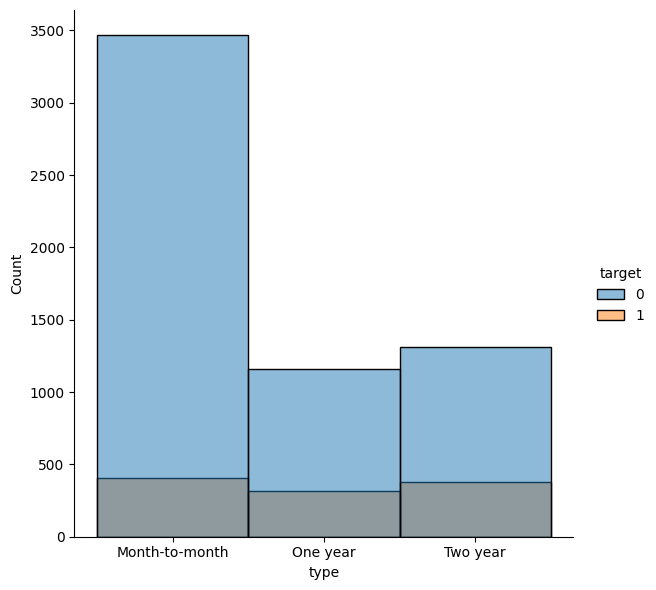

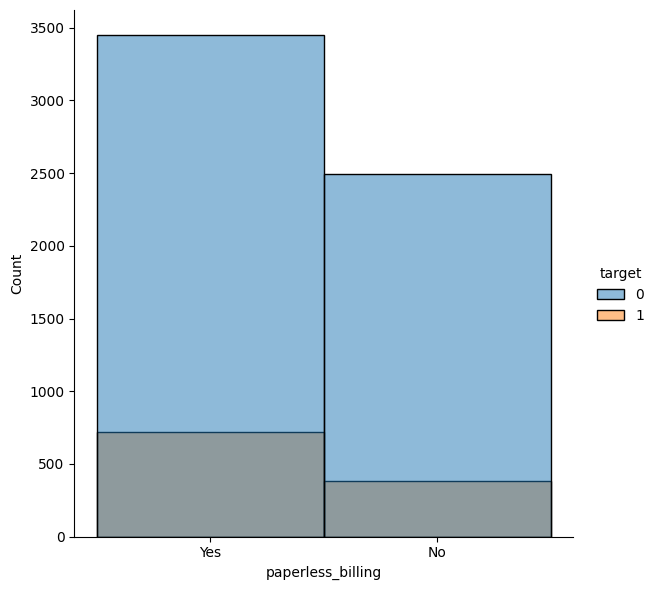

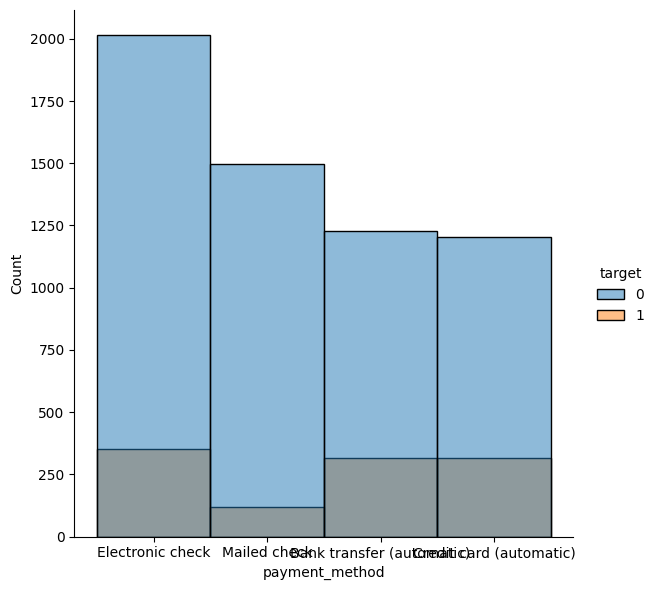

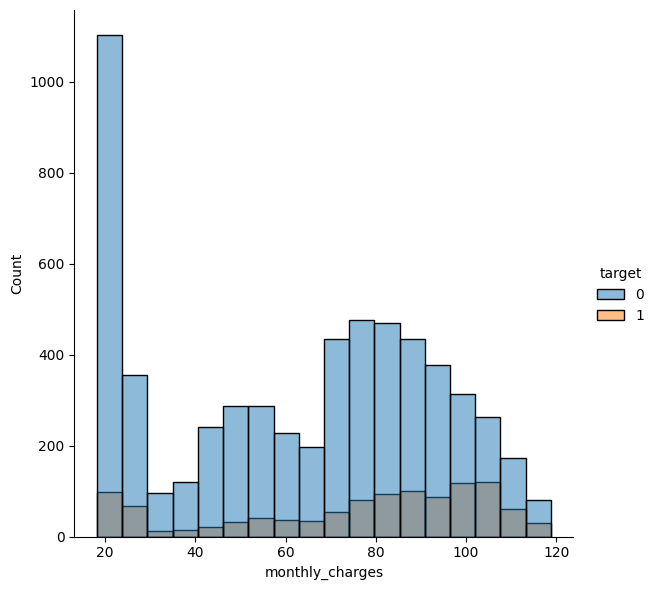

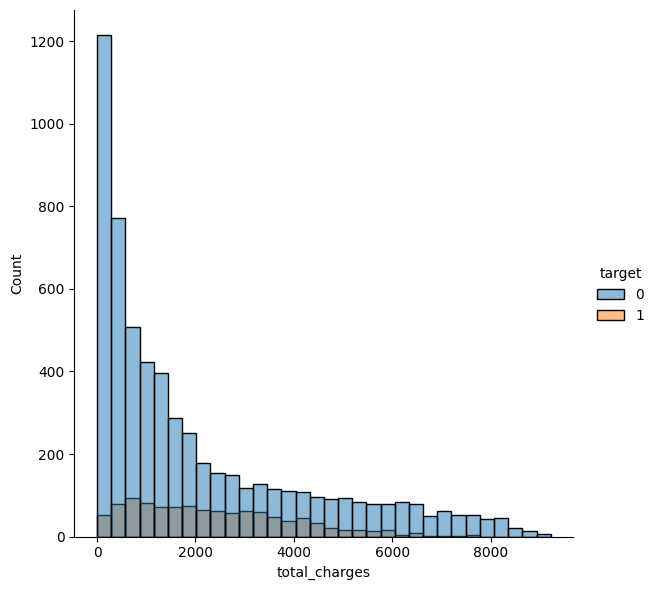

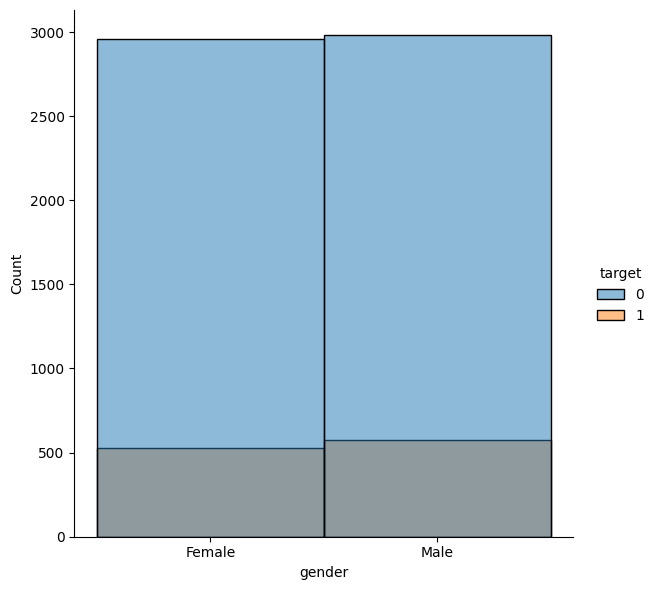

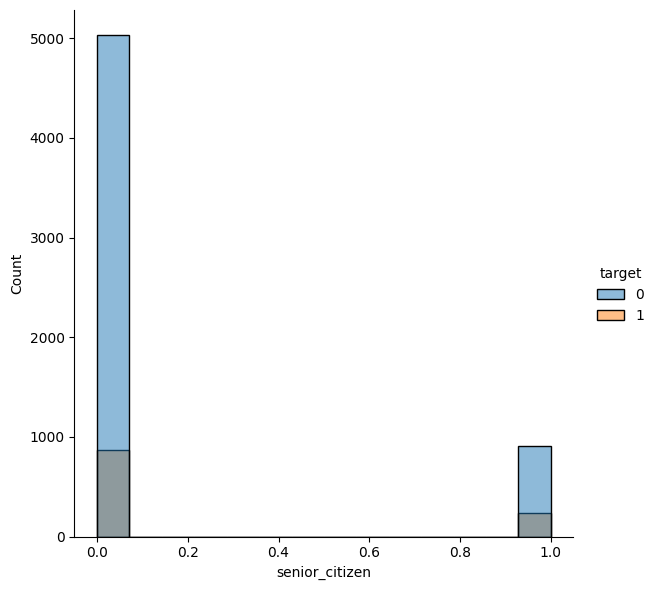

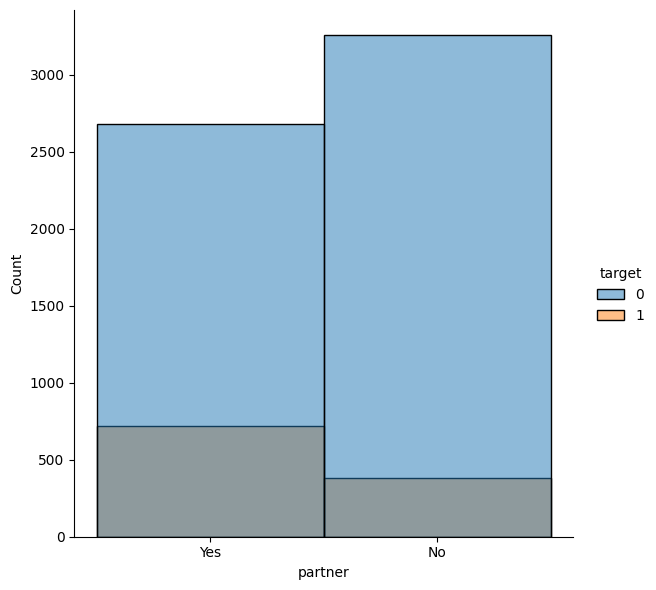

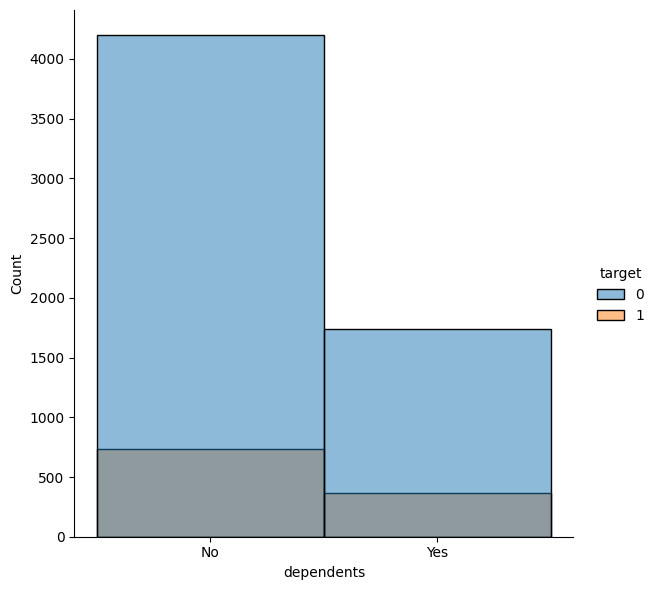

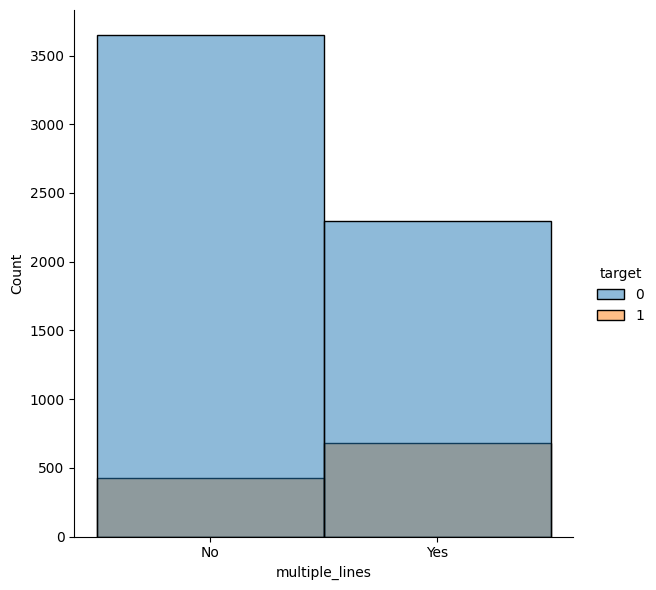

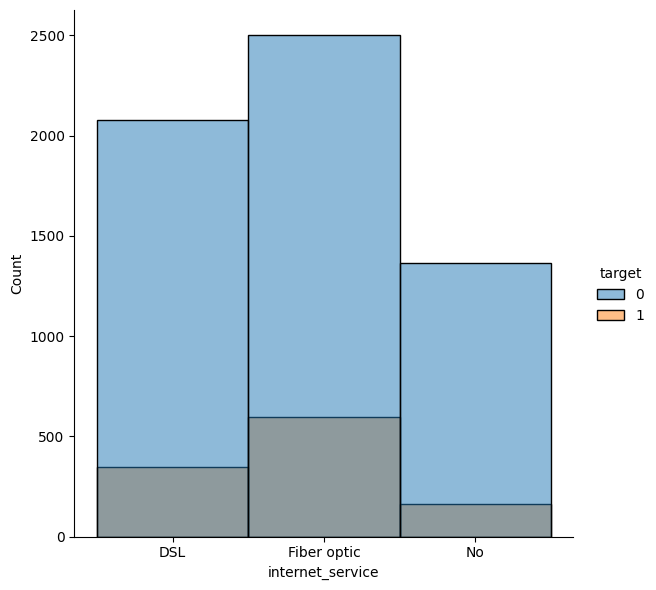

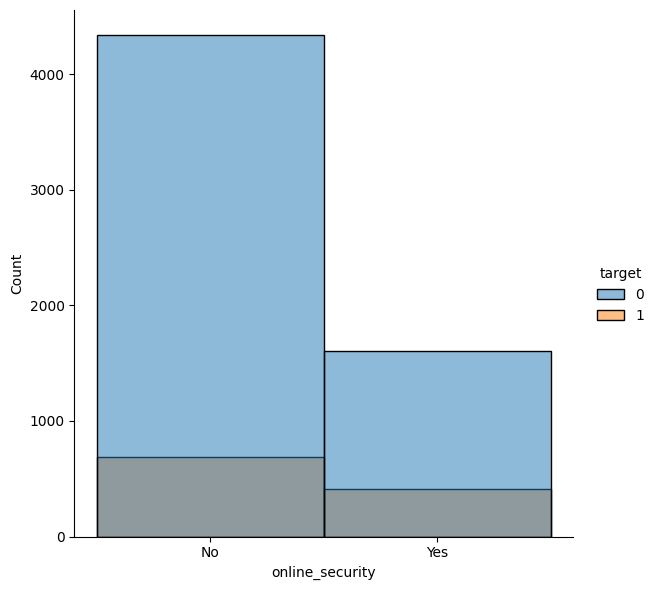

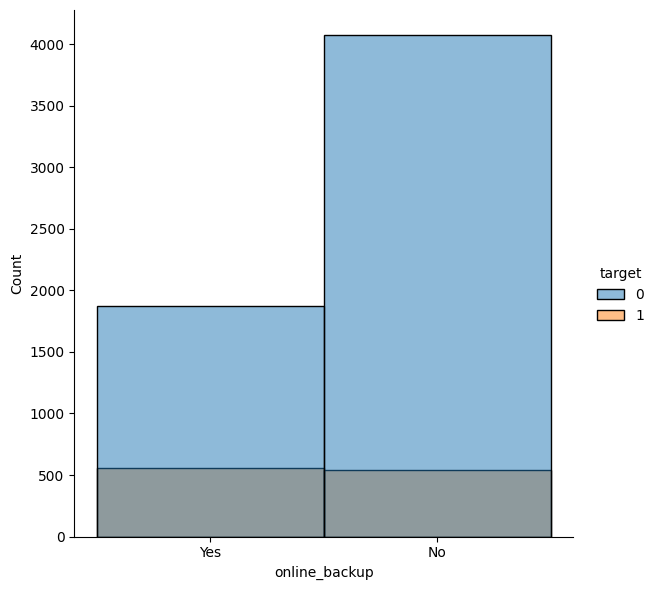

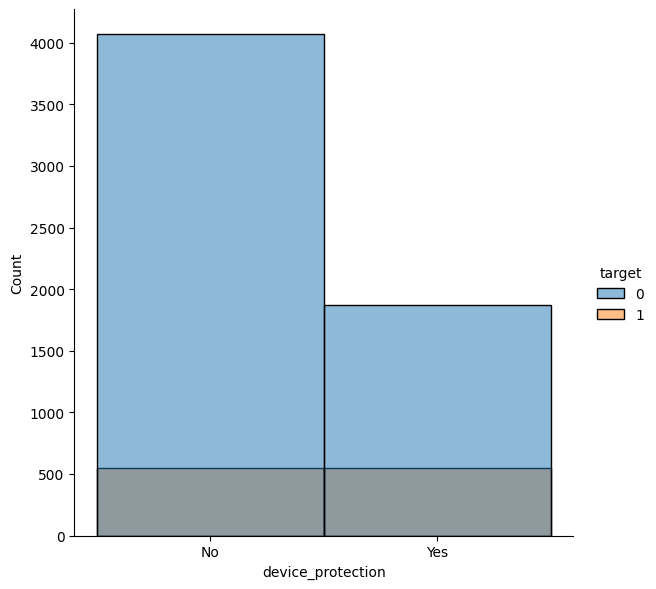

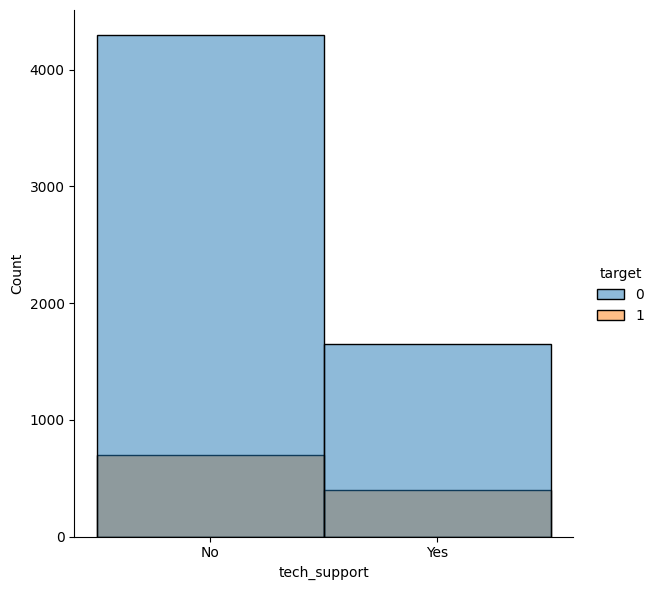

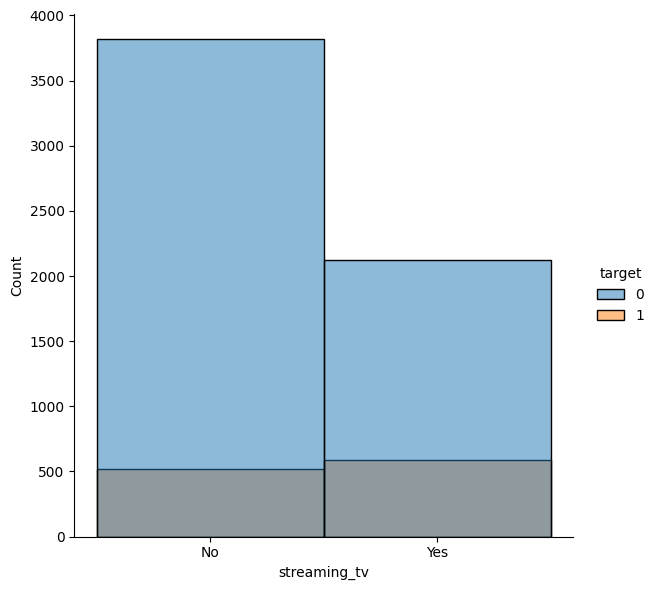

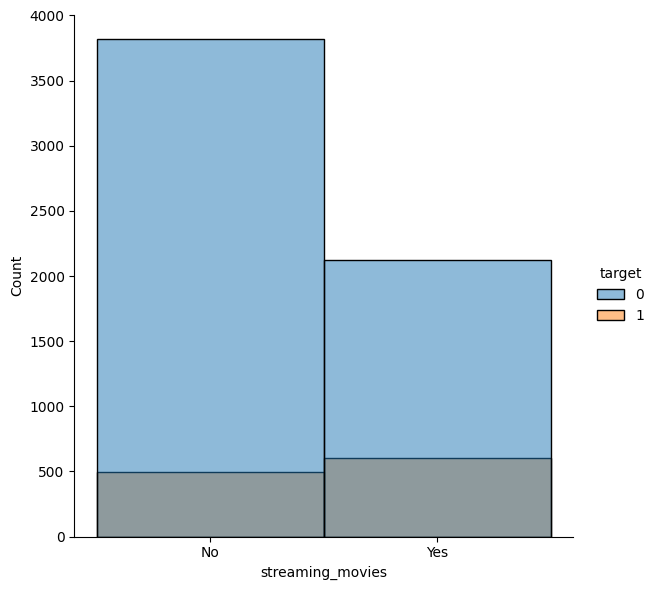

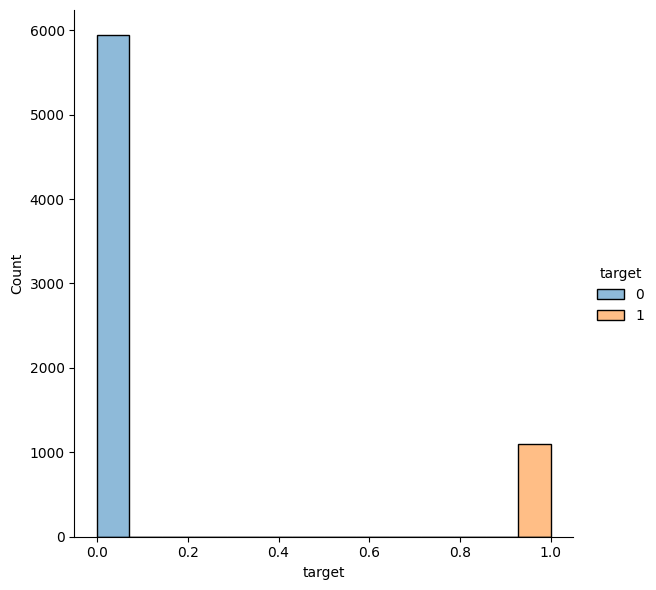

In [36]:
for_plot = list(data.columns)
for_plot.remove('customer_id')

for x in for_plot:
    sns.displot(data, x=x, kind='hist', hue='target', height=6)

### Вывод

Предобработка обнаружила несколько проблем в данных:

- пропущенные значения,
- неверные типы данных,
- стиль заголовков.

При анализе графиков были выявлены следующие закономерности:

- большинство ушедших клиентов пользовались такими функциями, как каталог фильмов, стриминговое телевидение, возможность ведения параллельных линий во время звонка
- минимальное количество дней контракта у ушедших клиентво составило 28, а максимальное — более 2000
- минимальная выплата в месяц у ушедших клиентов составляла около 20, а максимальная — более 100, при этом большинство ушедших клиентов платили более 100 в месяц.

Теперь можно перейти к подготовке данных.

## Подготовка данных

### Добавление столбцов

Добавим новый признак, значения в котором будут обозначать количество дней, которые провел клиент с компанией на момент выгрузки данных:

In [37]:
data['total_time'] = data['end_date'].dt.to_period('D').astype('int') - data['begin_date'].dt.to_period('D').astype('int')

### Удаление неинформативных признаков

Так как `customer_id` содержит уникальные id клиентов, то можно удалить данный столбец, так как это не повлияет на обучение модели:

In [38]:
data = data.drop(columns='customer_id', axis=1)

В предыдущем разделе был создан столбец `total_time`, поэтому можно удалить столбцы `begin_date` и `end_date`:

In [39]:
data = data.drop(columns=['begin_date', 'end_date'], axis=1)

### Разбиение данных на выборки

In [40]:
features = data.drop('target', axis=1)
target = data['target']

Разбиваем данные на обучающую и тестовую выборки в отношении 3:1:

In [41]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, stratify=target, random_state=RANDOM_STATE)

Количество объектов и признаков в обучающей выборке:

In [42]:
features_train.shape

(5282, 18)

Количество объектов и признаков в тестовой выборке:

In [43]:
features_test.shape

(1761, 18)

### Корреляция признаков

Рассмотрим матрицу корреляций признаков:

In [44]:
data.phik_matrix()

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'senior_citizen', 'target', 'total_time']


,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target,total_time
type,1.000000,0.106860,0.277462,0.388266,0.470860,0.000000,0.086231,0.179736,0.147680,0.065498,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.094015,0.634155
paperless_billing,0.106860,1.000000,0.370495,0.467783,0.201703,0.000000,0.242133,0.013218,0.172593,0.252972,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.083398,0.026799
payment_method,0.277462,0.370495,1.000000,0.399536,0.335666,0.000000,0.292725,0.243008,0.224903,0.339313,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.214832,0.350964
monthly_charges,0.388266,0.467783,0.399536,1.000000,0.711035,0.009025,0.304691,0.203237,0.184213,0.676233,0.918980,0.551631,0.629573,0.667685,0.576217,0.835225,0.833391,0.225925,0.387579
total_charges,0.470860,0.201703,0.335666,0.711035,1.000000,0.000000,0.135650,0.381958,0.084247,0.573191,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.302890,0.848337
gender,0.000000,0.000000,0.000000,0.009025,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.008581,0.000000
senior_citizen,0.086231,0.242133,0.292725,0.304691,0.135650,0.000000,1.000000,0.016992,0.324576,0.221313,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.086159,0.063315
partner,0.179736,0.013218,0.243008,0.203237,0.381958,0.000000,0.016992,1.000000,0.652122,0.220101,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.226688,0.453688
dependents,0.147680,0.172593,0.224903,0.184213,0.084247,0.000000,0.324576,0.652122,1.000000,0.033103,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.046871,0.198729
multiple_lines,0.065498,0.252972,0.339313,0.676233,0.573191,0.000000,0.221313,0.220101,0.033103,1.000000,0.225383,0.151886,0.311403,0.309757,0.155739,0.392239,0.394553,0.261237,0.398222


Высокая корреляция присутствует между признаками `monthly_charges` и `total_charges`.

### Вывод

На этапе подготовки был добавлен новый признак `total_time`, обозначающий количество месяцев, в течение которых клиент пользуется услугами компании, а также были удалены неинформативные признаки. После этого данные были разбиты на тренировочную и тестовую в отношении 3:1.
При анализе матрицы корреляции признаков были выявлены коррелирующие признаки: `monthly_charges` и `total_charges`.

## Обучение моделей

In [45]:
features_train_forest = features_train.copy()
features_test_forest = features_test.copy()

features_train_light = features_train.copy()
features_test_light = features_test.copy()

Определим названия колонок для последующих кодировки и масштабирования:

In [46]:
categorical = features_train.select_dtypes(include='object').columns.to_list() #категориальные признаки

numeric = features_train.select_dtypes(exclude='object').columns.to_list() #количественные признаки
numeric.remove('senior_citizen') #убираем данный столбец, так как он уже закодирован

Для обучения модели LightGBM изменим тип категориальных данных на `category`:

In [47]:
features_train_light[categorical] = features_train_light[categorical].astype('category')
features_test_light[categorical] = features_test_light[categorical].astype('category')

Для обучения моделей будем использовать pipeline, для этого готовим функции для масштабирования и кодирования и используемые модели:

In [48]:
transformer = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
        categorical
    ),
    (
        StandardScaler(),
        numeric
    ),
    remainder='passthrough'
)

forest = RandomForestClassifier(random_state=RANDOM_STATE)
lightgbm = lgb.LGBMClassifier()

### Случайный лес

In [49]:
pipeline_forest = make_pipeline(transformer, forest)

params_forest = {'randomforestclassifier__n_estimators' : range(50, 60, 1),
                 'randomforestclassifier__max_depth' : range(5, 20, 1)}

grid_forest = RandomizedSearchCV(
    pipeline_forest,
    param_distributions=params_forest,
    scoring='roc_auc',
    n_iter=100,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

grid_forest.fit(features_train_forest, target_train)

best_score = grid_forest.best_score_
best_params = grid_forest.best_params_
print(f'best_score: {best_score}')
print(f'best_params: {best_params}')

best_score: 0.8262330475329887
best_params: {'randomforestclassifier__n_estimators': 51, 'randomforestclassifier__max_depth': 7}


### LightGBM

In [50]:
pipeline_light = make_pipeline(lightgbm)

params_light = {'lgbmclassifier__n_estimators' : range(70, 80, 1),
                'lgbmclassifier__max_depth' : range(10, 20, 1)}

grid_light = RandomizedSearchCV(
    pipeline_light,
    param_distributions=params_light,
    scoring='roc_auc',
    n_iter=100,
    n_jobs=-1,
    random_state=RANDOM_STATE
)

grid_light.fit(features_train_light, target_train)

light_best_score = grid_light.best_score_
light_best_params = grid_light.best_params_
print(f'best_score: {light_best_score}')
print(f'best_params: {light_best_params}')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 826, number of negative: 4456
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 737
[LightGBM] [Info] Number of data points in the train set: 5282, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156380 -> initscore=-1.685412
[LightGBM] [Info] Start training from score -1.685412
best_score: 0.8534748934965428
best_params: {'lgbmclassifier__n_estimators': 79, 'lgbmclassifier__max_depth': 11}


### Вывод

С помощью `RandomizedSearchCV` через пайплайн в данном разделе были подобраны гиперпараметры и обучены модели случайного леса и LightGBM. LightGBM показала лучшую ROC-AUC метрику.

## Анализ модели и тестирование

### Построение ROC-кривой

Построим ROC-кривую для модели LightGBM:

In [51]:
probabilities_test = grid_light.best_estimator_.predict_proba(features_test_light)
probabilities_one_test = probabilities_test[:, 1]

print('AUC-ROC:', roc_auc_score(target_test, probabilities_one_test))
print(probabilities_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
AUC-ROC: 0.8712418940413557
[[0.98890533 0.01109467]
 [0.41693485 0.58306515]
 [0.95910203 0.04089797]
 ...
 [0.76134601 0.23865399]
 [0.90599505 0.09400495]
 [0.75215173 0.24784827]]


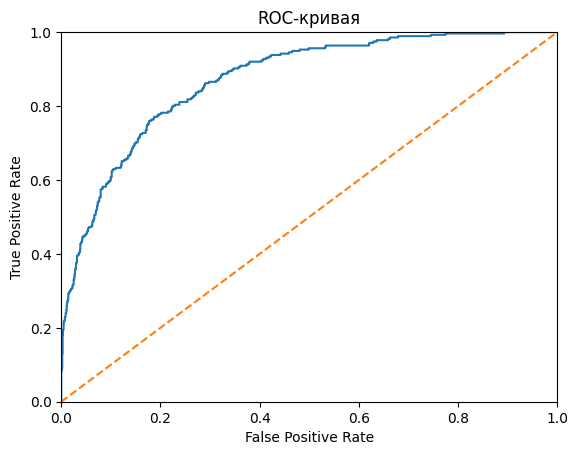

In [52]:
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)

plt.figure()

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC-кривая')

plt.show()

### Важность признаков

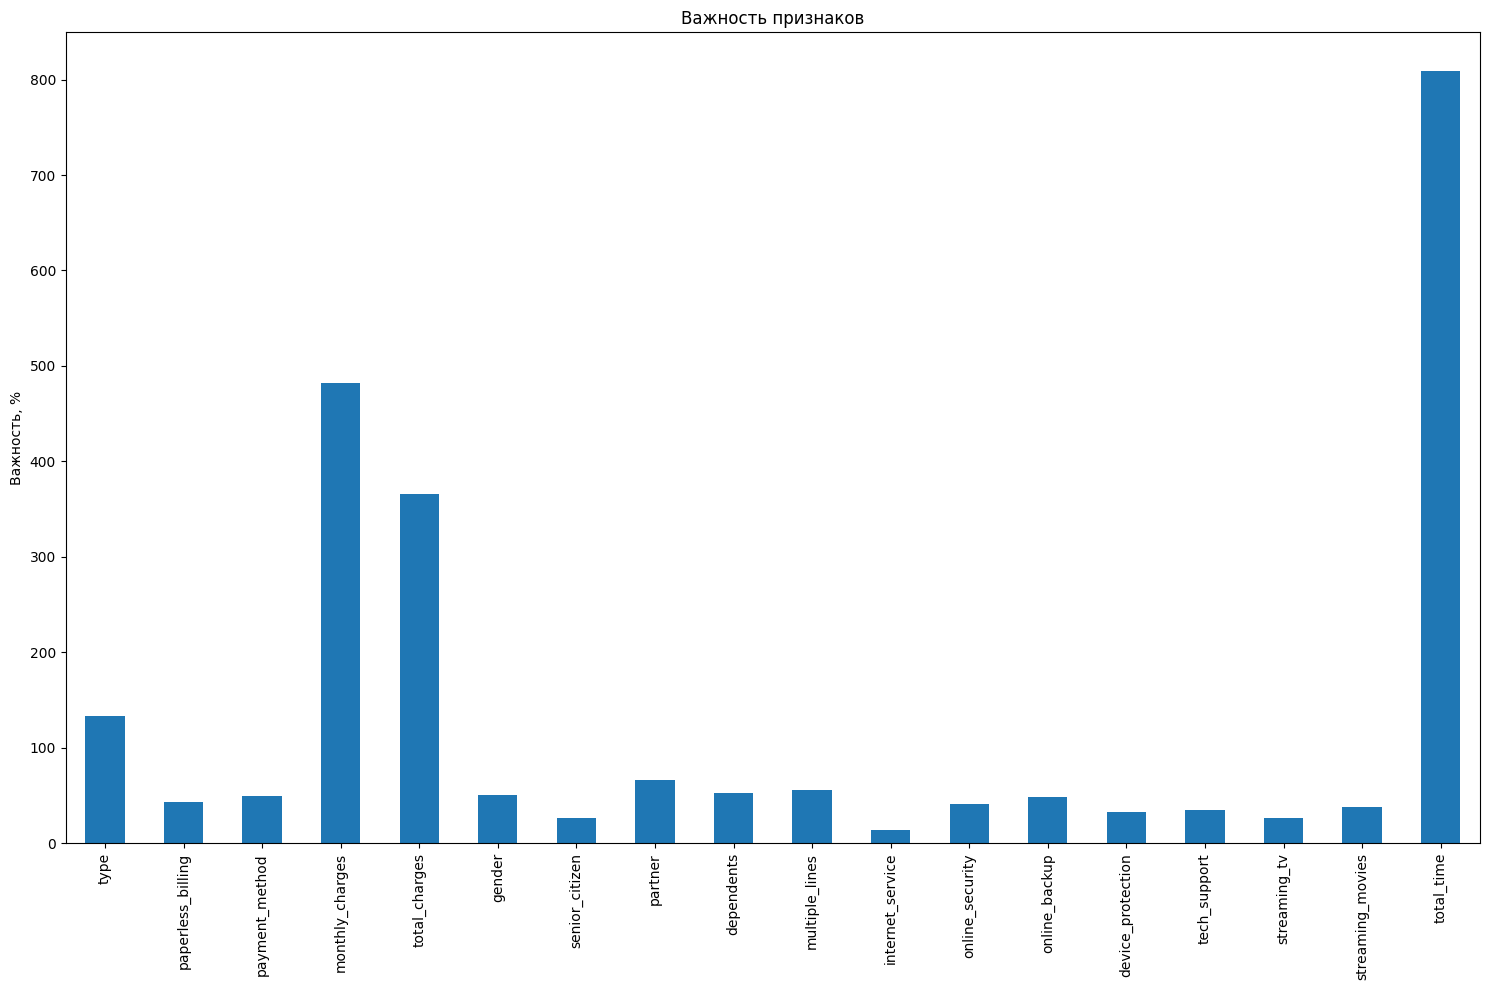

In [53]:
feature_imp = pd.Series(grid_light.best_estimator_[0].feature_importances_,
                         features_train_light.columns)

fig, ax = plt.subplots(figsize=(15,10))
feature_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

### Вывод

При тестировании модель LightGBM выдает высокое значение метрики AUC-ROC. На графике важности признаков видно, что модель больше всего котирует такие признаки, как `monthly_charges`, `total_charges` и `total_time`.

## Отчет

* Какие пункты плана были выполнены, а какие — нет. Почему?

Все пункты плана были выполнены, но кодирование и масштабирование были произведены только для модели случайного леса, так как для модели LightGBM это не требуется.

* Какие трудности возникли и как вы их преодолели?

Трудности возникли с преодолением порогового значения AUC-ROC, но с помощью изменения диапазона подбора гиперпараметров необходимое значение было получено.

* Какие ключевые шаги в решении задачи вы выделили?

1. Изучение общей информации датафрейма

2. Предобработка данных

3. Подготовка данных для дальнейшего корректного обучения моделей

4. Обучение моделей и поиск наилучших моделей с помощью подбора гиперпараметров

5. Тестирование лучшей по метрике модели

* Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?

Для обучения моделей были использованы все признаки, кроме `customer_id`, `begin_date` и `end_date`, а на основе двух последних признаков был создан новый — `total_time`. В признаках были заполнены пропуски, а также изменены типы данных.

* Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?

Итоговой моделью является модель LightGBM, у которой n_estimators=79 и max_depth=11. Значение AUC-ROC данной модели на тестовой выборке составило примерно 0.87.

Для удобства все датафреймы были соединены по столбцу `customer_id`. Для обучения моделей использовались все признаки, кроме `customer_id`, `begin_date` и `end_date`, а на основе двух последних признаков был создан новый — `total_time`, содержащий количество дней договора для каждого клиента.

В предобработке данных был добавлен целевой признак `target`, так как явно в датафрейме он не был обозначен, после чего все неверные типы данных были изменены, а пропуски в столбце `total_charges` заполнены.

Для успешного обучения моделей была произведена подготовка данных: данные были разбиты на обучающую и тестовую выборку в отношении 3:1, после чего была рассмотрена корреляция признаков. Высоко корелирующих признаков, кроме `monthly_charges` и `total_charges`, обнаружено не было.

Далее были рассмотрены две модели: модель случайного леса и LightGBM. С помощью RandomizedSearchCV через пайплайн были подобраны гиперпараметры лучших по AUC-ROC моделей. Таблица сравнения значений ниже:

In [54]:
result = pd.DataFrame(
    [best_score, light_best_score],
    index=['Случайный лес', 'LightGBM'],
    columns=['AUC-ROC']
)
result

,AUC-ROC
Случайный лес,0.826233
LightGBM,0.853475


Лучшей моделью стала LightGBM с гиперпараметрами n_estimators=79 и max_depth=11. Данная модель была протестирована, и на тестовой выборке было получено значение AUC-ROC, равное примерно 0.87.

Рассмотрим важность признаков для модели LightGBM:

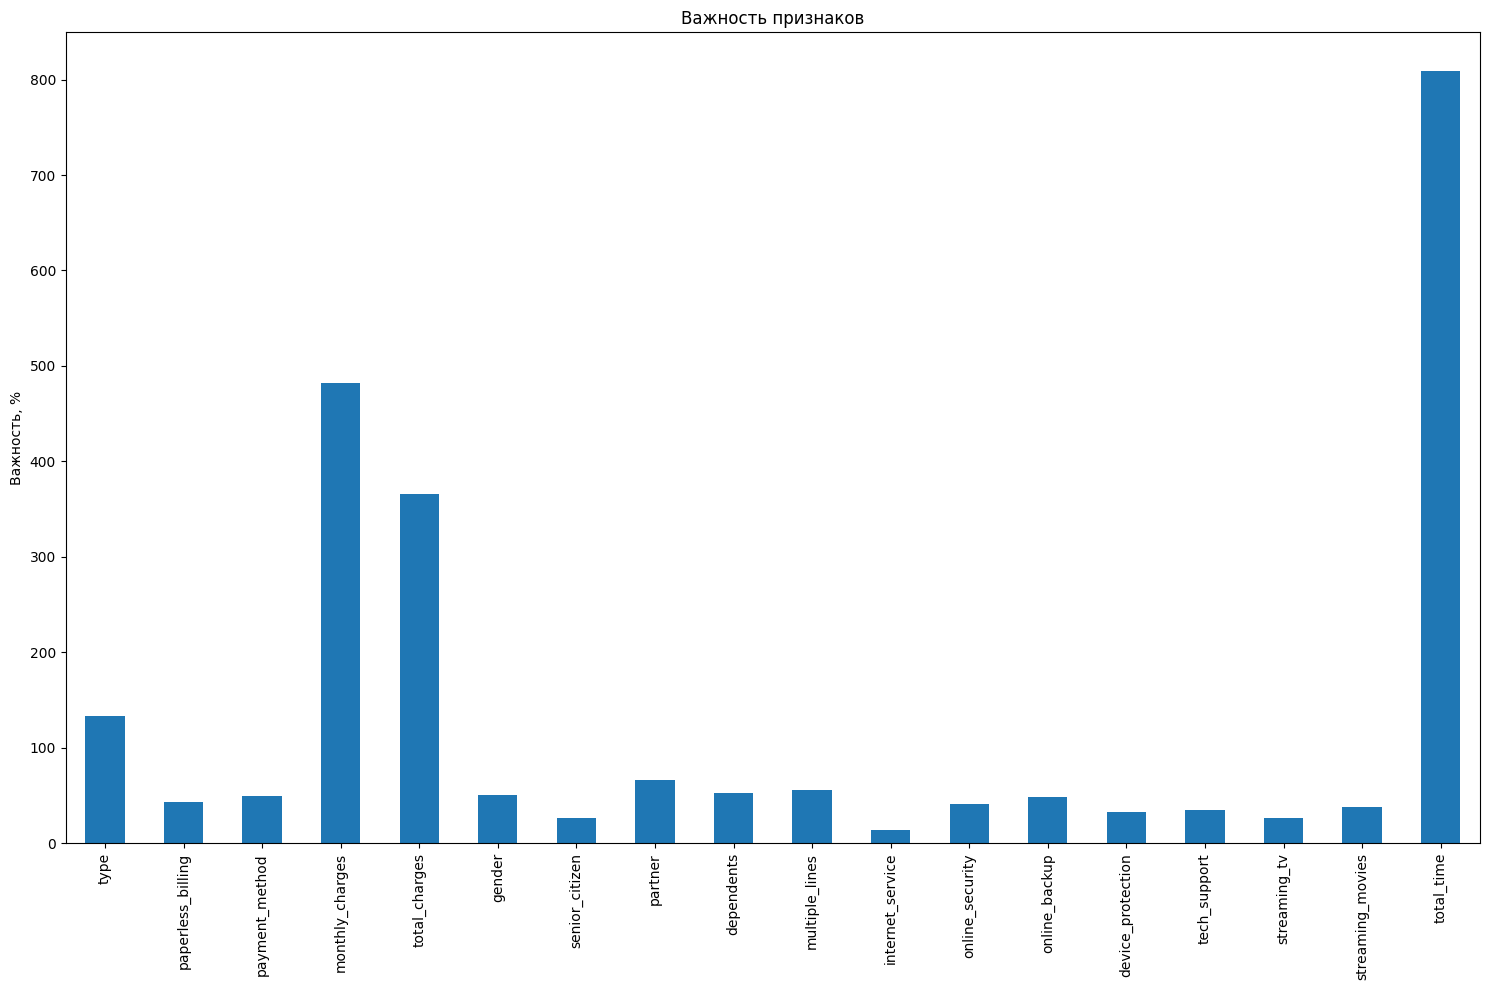

In [55]:
fig, ax = plt.subplots(figsize=(15,10))
feature_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

На графике заметно, что LightGBM котирует по большей части количественные признаки:
* `total_time` — количество дней, которые клиент провел пользуясь услугами компании,
* `monthly_charges` — ежемесячные траты на услуги,
* `total_charges` — общие траты на услуги за все время пребывания с компанией.